In [1]:
# The Fifth Workshop on Computer Modelling in Decision Making (CMDM 2020)
# November 26, 27 2020
#
# Making decisions on issuing sub-federal bonds: key factors modeling
#
# Alla Yakunina, Alexey Mitrofanov, Elena Ermakova, Sergey Yakunin, Eugene Korobov and Yulia Semernina

In [2]:
library(stargazer)
library(texreg)
library(ggplot2)
library(ggpubr)
library(pglm)
library(bbmle)
library(glmmTMB)
library(DHARMa)
library(ggfortify)


Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


Version:  1.37.5
Date:     2020-06-17
Author:   Philip Leifeld (University of Essex)

Consider submitting praise using the praise or praise_interactive functions.
Please cite the JSS article in your publications -- see citation("texreg").

Loading required package: maxLik

Loading required package: miscTools


Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/

Loading required package: plm

Loading required package: stats4


Attaching package: ‘bbmle’


The followin

In [3]:
theme_set(theme_pubr())

In [4]:
source("catvec.R")

## Data Preparation

In [5]:
# data import
RBV <- rio::import("RBV.xlsx", setclass = "tibble")
BLP <- rio::import("BLP.xlsx", setclass = "tibble")
ACCI <- rio::import("ACCI.xlsx", setclass = "tibble")
DL <- rio::import("DL.xlsx", setclass = "tibble")
RBS <- rio::import("RBS.xlsx", setclass = "tibble")
EMPL <- rio::import("EMPL.xlsx", setclass = "tibble")
KR <- rio::import("KR.xlsx", setclass = "tibble")

In [6]:
# correction of regions' names
regi <- sort(unique(c(ACCI$region,BLP$region,DL$region,EMPL$region,KR$region,RBS$region,RBV$region)))
regi <- setdiff(regi, c('г.Москва', 'г.Санкт-Петербург', 'г.Севастополь',
                        'Республика Северная Осетия-Алания',
                        'Чеченская республика',
                        'Удмуртская республика',
                        'Чувашская Республика-Чувашия',
                        'Тюменская область без авт. округов',
                        'Ханты-Мансийский автономный округ - Югра',
                        'Кемеровская область - Кузбасс'))
catvec(paste0(1:length(regi), ". ", regi))

1. Алтайский край 
2. Амурская область 
3. Архангельская область 
4. Астраханская область 
5. Белгородская область 
6. Брянская область 
7. Владимирская область 
8. Волгоградская область 
9. Вологодская область 
10. Воронежская область 
11. г. Москва 
12. г. Санкт-Петербург 
13. г. Севастополь 
14. Еврейская автономная область 
15. Забайкальский край 
16. Ивановская область 
17. Иркутская область 
18. Кабардино-Балкарская Республика 
19. Калининградская область 
20. Калужская область 
21. Камчатский край 
22. Карачаево-Черкесская Республика 
23. Кемеровская область 
24. Кировская область 
25. Костромская область 
26. Краснодарский край 
27. Красноярский край 
28. Курганская область 
29. Курская область 
30. Ленинградская область 
31. Липецкая область 
32. Магаданская область 
33. Московская область 
34. Мурманская область 
35. Ненецкий автономный округ 
36. Нижегородская область 
37. Новгородская область 
38. Новосибирская область 
39. Омская область 
40. Оренбургская область 
41. Орло

In [7]:
ACCI$region[ACCI$region %in% setdiff(ACCI$region, regi)] <- regi[c(59, 81, 76, 82, 75)]
BLP$region[BLP$region %in% setdiff(BLP$region, regi)] <- regi[c(11:13, 79, 23)]
DL$region[DL$region %in% setdiff(DL$region, regi)] <- regi[c(81, 76, 79, 23)]
EMPL$region[EMPL$region %in% setdiff(EMPL$region, regi)] <- regi[c(59, 81, 76, 82)]
KR$region[KR$region %in% setdiff(KR$region, regi)] <- regi[c(11:13, 79)]
RBS$region[RBS$region %in% setdiff(RBS$region, regi)] <- regi[c(59, 81, 76, 82)]
RBV$region[RBV$region %in% setdiff(RBV$region, regi)] <- regi[c(11:13, 79)]

In [8]:
# test that all names were corrected
setdiff(sort(unique(c(ACCI$region,BLP$region,DL$region,EMPL$region,KR$region,RBS$region,RBV$region))), regi)
setdiff(regi, ACCI$region)
setdiff(regi, BLP$region)
setdiff(regi, DL$region)
setdiff(regi, EMPL$region)
setdiff(regi, KR$region)
setdiff(regi, RBS$region)
setdiff(regi, RBV$region)

character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

In [9]:
# test if in all tables regions' names are all the same
foo <- cbind(ACCI$region,BLP$region,DL$region,EMPL$region,KR$region,RBS$region,RBV$region)
all(apply(foo, 1, unique) == foo[, 1])

[1] TRUE

In [10]:
# melting tables
ACCIm <- reshape2::melt(ACCI, id = "region", variable.name = "month", value.name = "ACCI")
BLPm <- reshape2::melt(BLP, id = "region", variable.name = "month", value.name = "BLP")
DLm <- reshape2::melt(DL, id = "region", variable.name = "month", value.name = "DL")
EMPLm <- reshape2::melt(EMPL, id = "region", variable.name = "month", value.name = "EMPL")
KRm <- reshape2::melt(KR, id = "region", variable.name = "month", value.name = "KR")
RBSm <- reshape2::melt(RBS, id = "region", variable.name = "month", value.name = "RBS")
RBVm <- reshape2::melt(RBV, id = "region", variable.name = "month", value.name = "RBV")

In [11]:
# joining tables
foo <- plyr::join(RBVm, BLPm, by = c("region", "month"))
foo <- plyr::join(foo, KRm, by = c("region", "month"))
foo <- plyr::join(foo, ACCIm, by = c("region", "month"))
foo <- plyr::join(foo, DLm, by = c("region", "month"))
foo <- plyr::join(foo, RBSm, by = c("region", "month"))
foo <- plyr::join(foo, EMPLm, by = c("region", "month"))

In [12]:
head(foo)

,region,month,RBV,BLP,KR,ACCI,DL,RBS,EMPL
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,Белгородская область,month1,11000000,12.92685,17,19943,NA,NA,782.80
2,Брянская область,month1,0,22.71008,17,17136,NA,NA,601.78
3,Владимирская область,month1,0,100.00000,17,17539,NA,NA,732.23
4,Воронежская область,month1,14313000,18.86869,17,20715,NA,NA,1104.89
5,Ивановская область,month1,0,22.88792,17,13947,NA,NA,530.96
6,Калужская область,month1,2500000,27.25749,17,20121,NA,NA,515.23


In [13]:
# convert DL, RBS to double
foo$DL <- as.double(foo$DL)
foo$RBS <- as.double(foo$RBS)

Warning message in eval(expr, envir, enclos):
“в результате преобразования созданы NA”
Warning message in eval(expr, envir, enclos):
“в результате преобразования созданы NA”


In [14]:
da <- foo
rm(foo)

In [15]:
# region as factor
da$region <- as.factor(da$region)

In [16]:
# add dummy for December 2018
da$D201812 <- as.integer(da$month == "month48")

In [17]:
# rounding of RBV
da$RBVrnd <- as.integer(round(da$RBV/1e5))

In [18]:
# dummy for RBVrnd > 0
da$RBVnz <- as.factor(as.integer(da$RBVrnd > 0))

In [19]:
# remove all objects but da
rm(list=setdiff(ls(), "da"))

In [20]:
head(da)

,region,month,RBV,BLP,KR,ACCI,DL,RBS,EMPL,D201812,RBVrnd,RBVnz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>
1,Белгородская область,month1,11000000,12.92685,17,19943,NA,NA,782.80,0,110,1
2,Брянская область,month1,0,22.71008,17,17136,NA,NA,601.78,0,0,0
3,Владимирская область,month1,0,100.00000,17,17539,NA,NA,732.23,0,0,0
4,Воронежская область,month1,14313000,18.86869,17,20715,NA,NA,1104.89,0,143,1
5,Ивановская область,month1,0,22.88792,17,13947,NA,NA,530.96,0,0,0
6,Калужская область,month1,2500000,27.25749,17,20121,NA,NA,515.23,0,25,1


## Distributions/Transformations of Predictors

In [21]:
#===== BLP ====================================================

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   31.55   50.42   51.66   70.79  100.00 

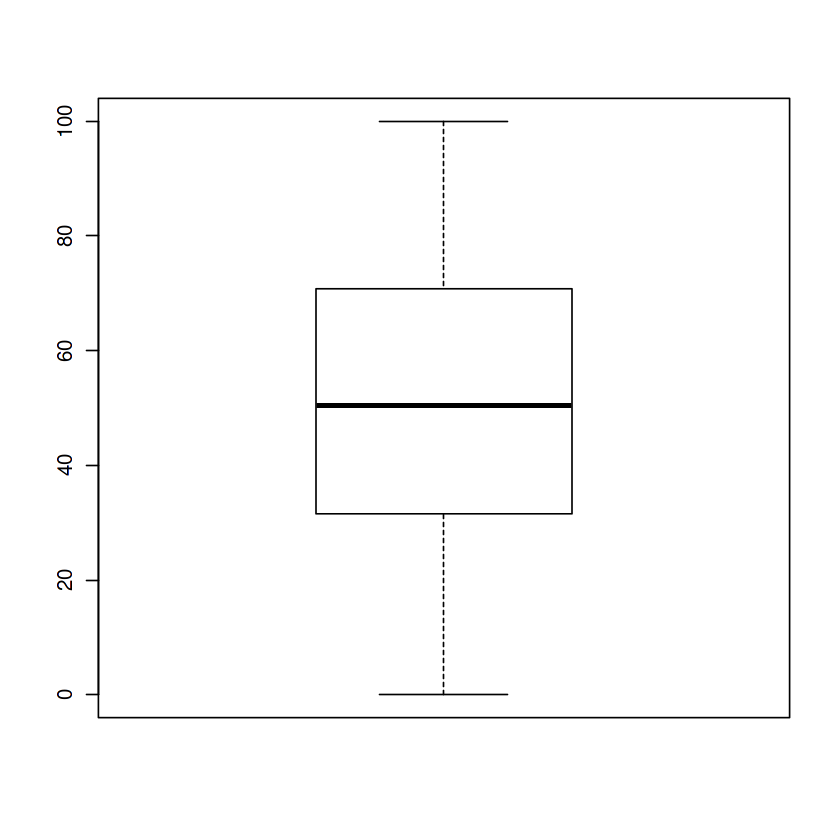

In [22]:
summary(da$BLP)
boxplot(da$BLP)

In [23]:
# symmetric distribution

In [24]:
#===== KR ===========================================================

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.000   7.500   9.000   9.324  11.000  17.000 

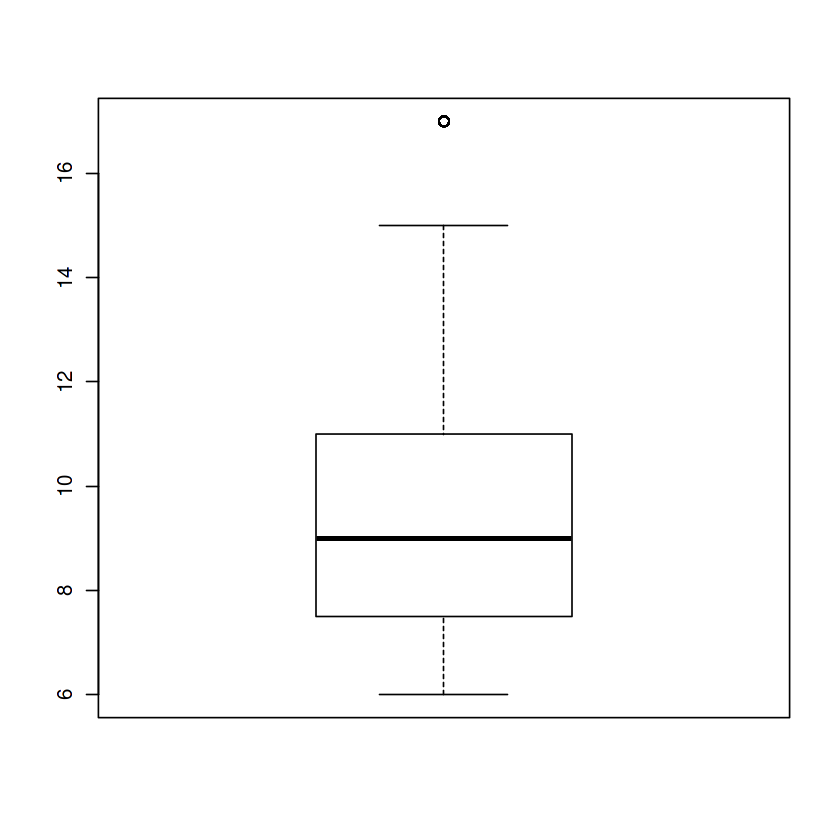

In [25]:
summary(da$KR)
boxplot(da$KR)

In [26]:
# slight As > 0

In [27]:
#===== ACCI ====================================================

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   5223   22297   26332   29743   33188  150843     340 

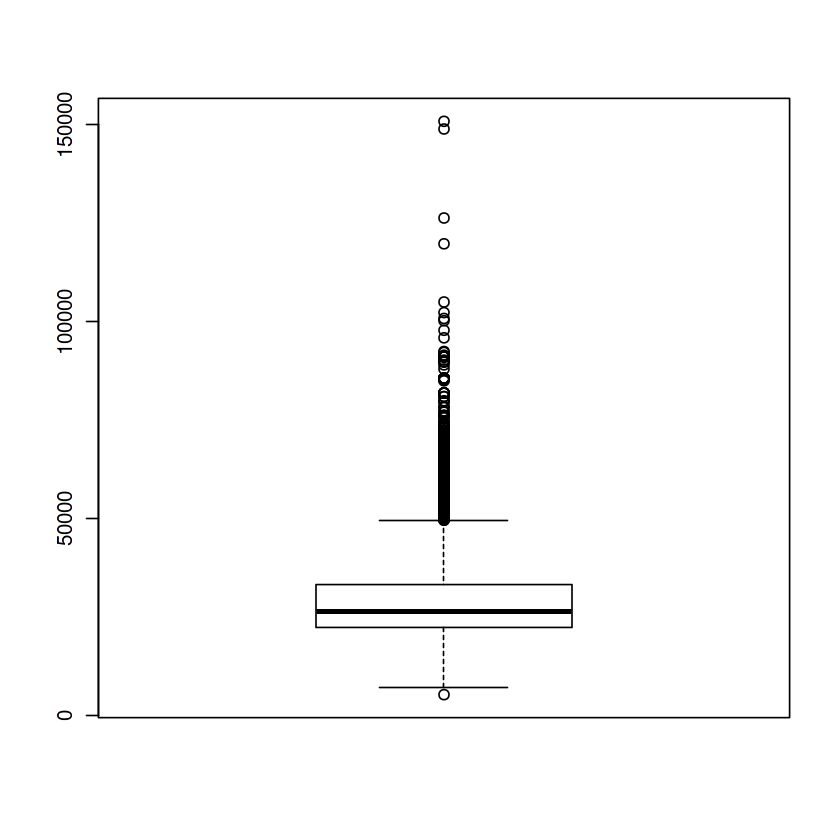

In [28]:
summary(da$ACCI)
boxplot(da$ACCI)

In [29]:
# As > 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  8.561  10.012  10.179  10.229  10.410  11.924     340 

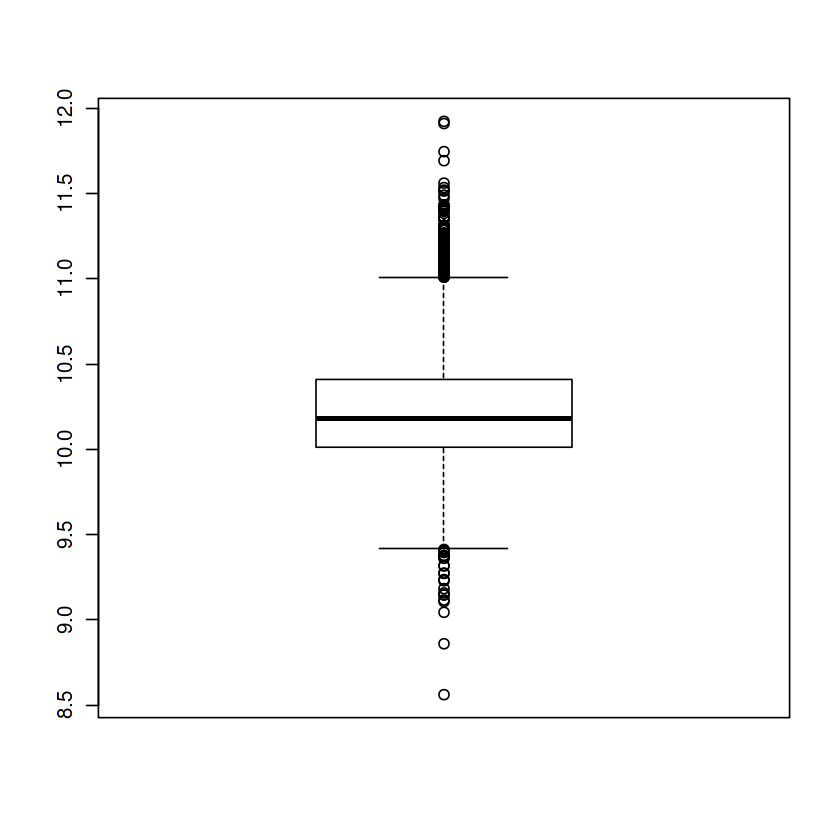

In [30]:
summary(log(da$ACCI))
boxplot(log(da$ACCI))

In [31]:
# symmetric, thick tails

In [32]:
#===== DL =====================================================

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   30.21   55.36   55.14   78.53  230.19     307 

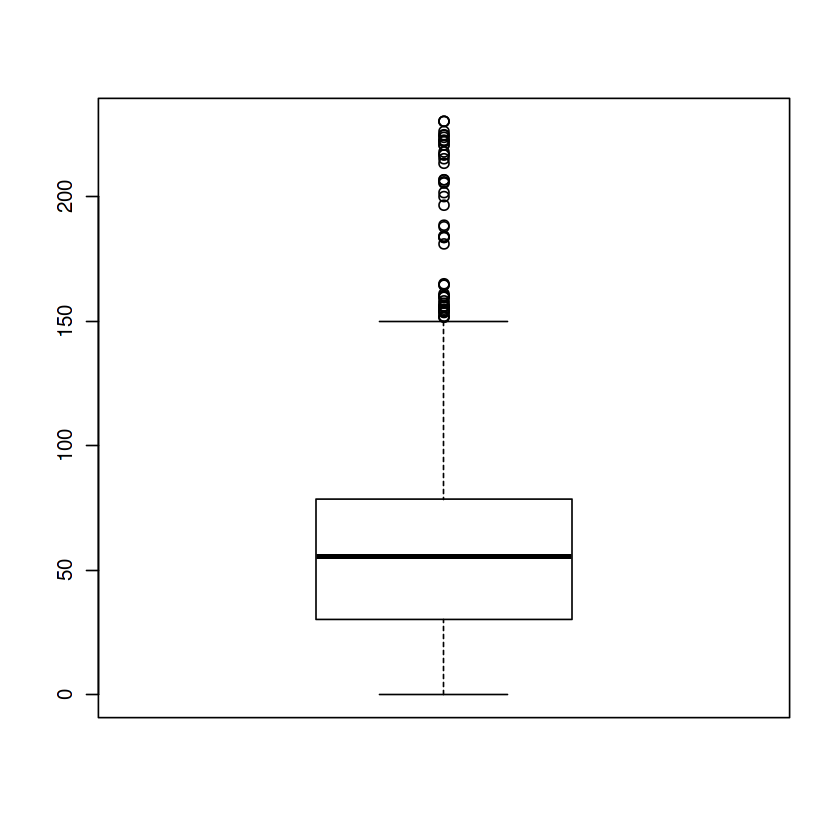

In [33]:
summary(da$DL)
boxplot(da$DL)

In [34]:
# As > 0

In [35]:
#===== RBS ===============================================

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-67511.0   -980.1    303.9   4783.0   3173.1 381541.2      343 

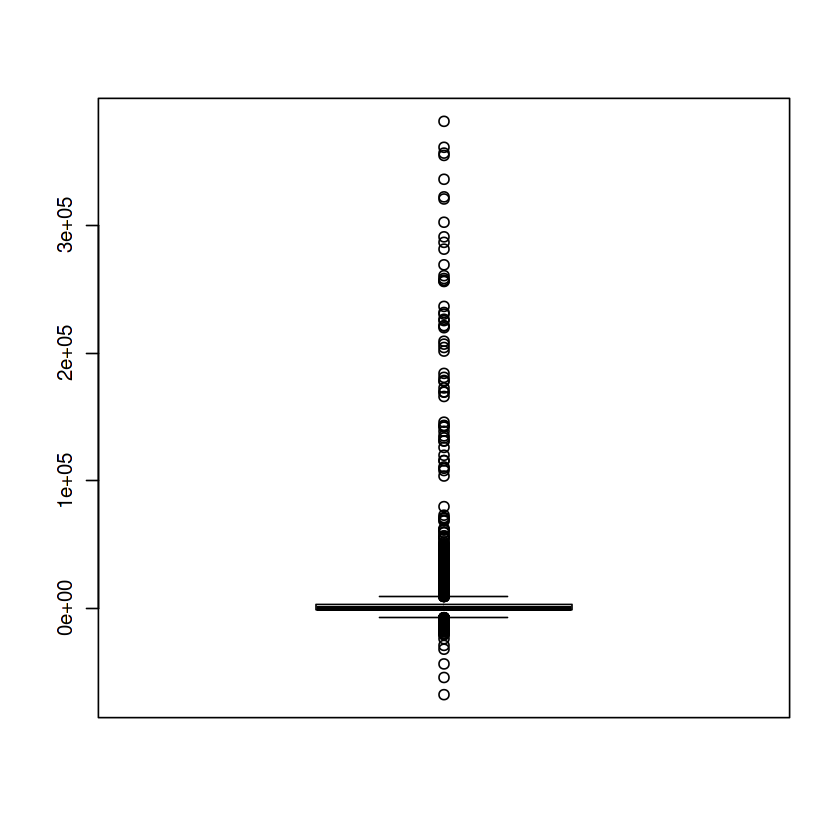

In [36]:
summary(da$RBS)
boxplot(da$RBS)

In [37]:
# As >> 0, thick tails

In [38]:
trans_rbs <- function(x, pow = 1/4) {
    # power transform for signed data
    y <- x
    xpos <- !is.na(x) & x >= 0
    xneg <- !is.na(x) & x < 0
    
    y[xpos] <- (x[xpos])^pow
    y[xneg] <- -(-x[xneg])^pow
    y
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-16.119  -5.595   4.175   1.693   7.505  24.853     343 

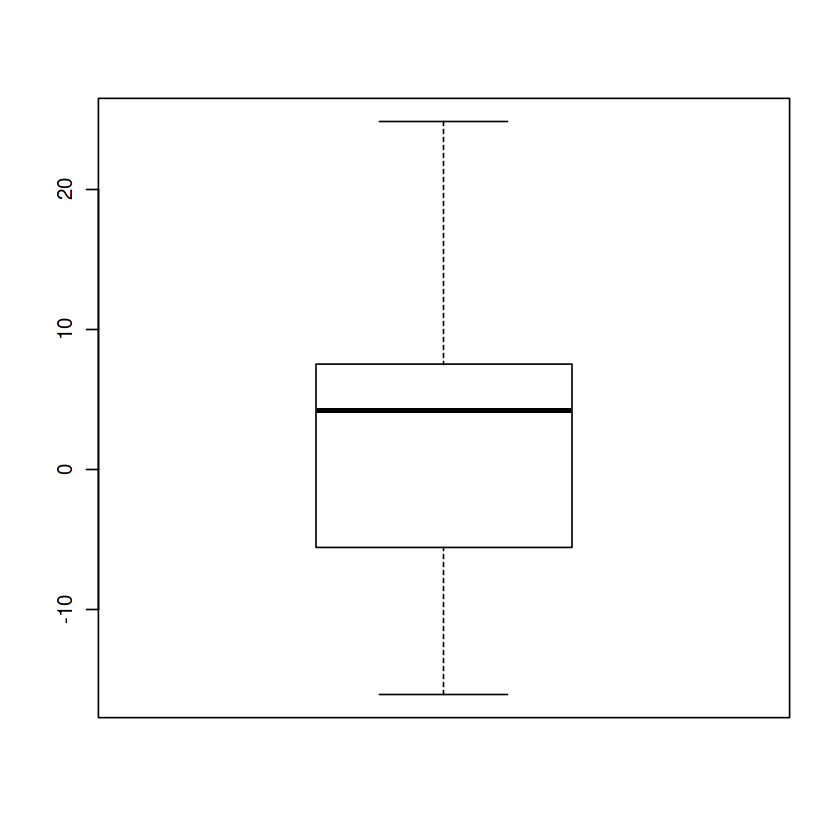

In [39]:
summary(trans_rbs(da$RBS))
boxplot(trans_rbs(da$RBS))

In [40]:
# close to symmetric

In [41]:
#===== EMPL =================================

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  19.13  340.70  555.69  849.58 1081.24 7294.20       6 

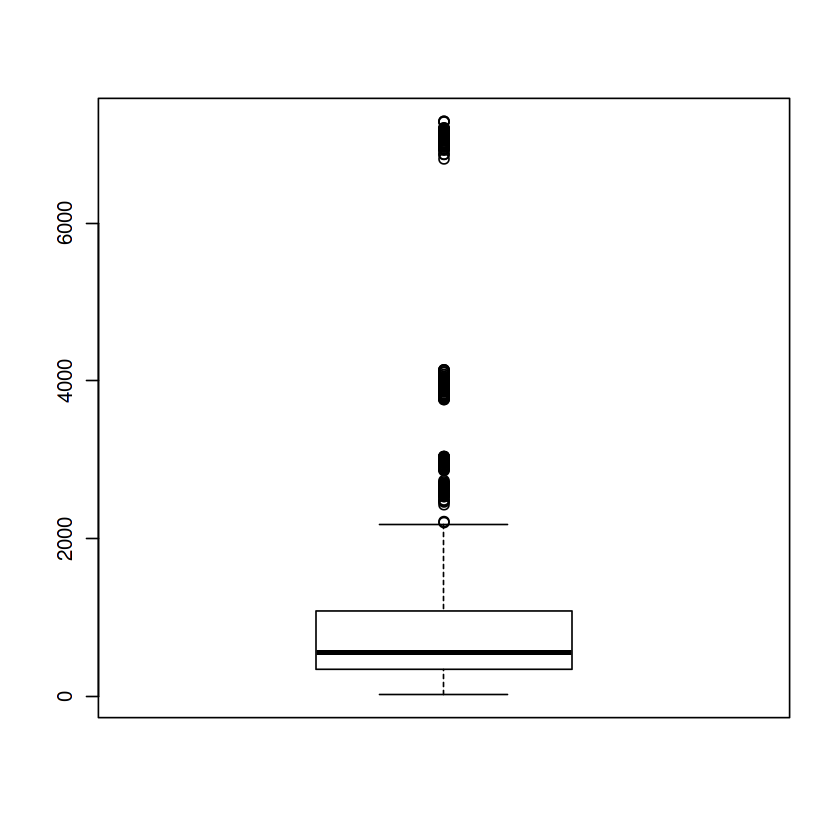

In [42]:
summary(da$EMPL)
boxplot(da$EMPL)

In [43]:
# As >> 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  2.951   5.831   6.320   6.316   6.986   8.895       6 

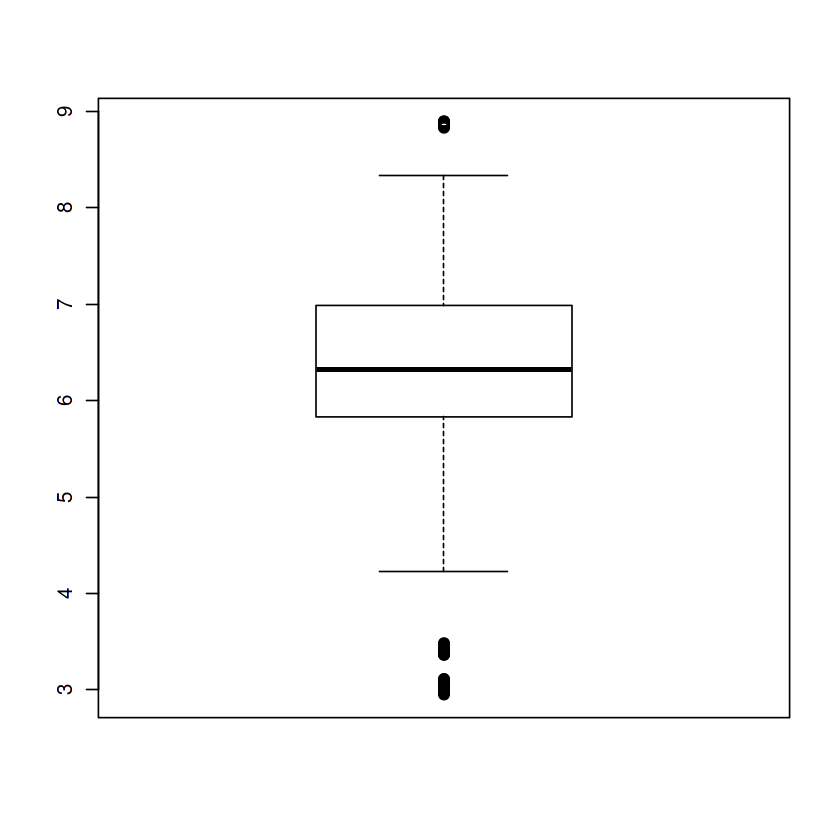

In [44]:
summary(log(da$EMPL))
boxplot(log(da$EMPL))

In [45]:
# symmetric distribution

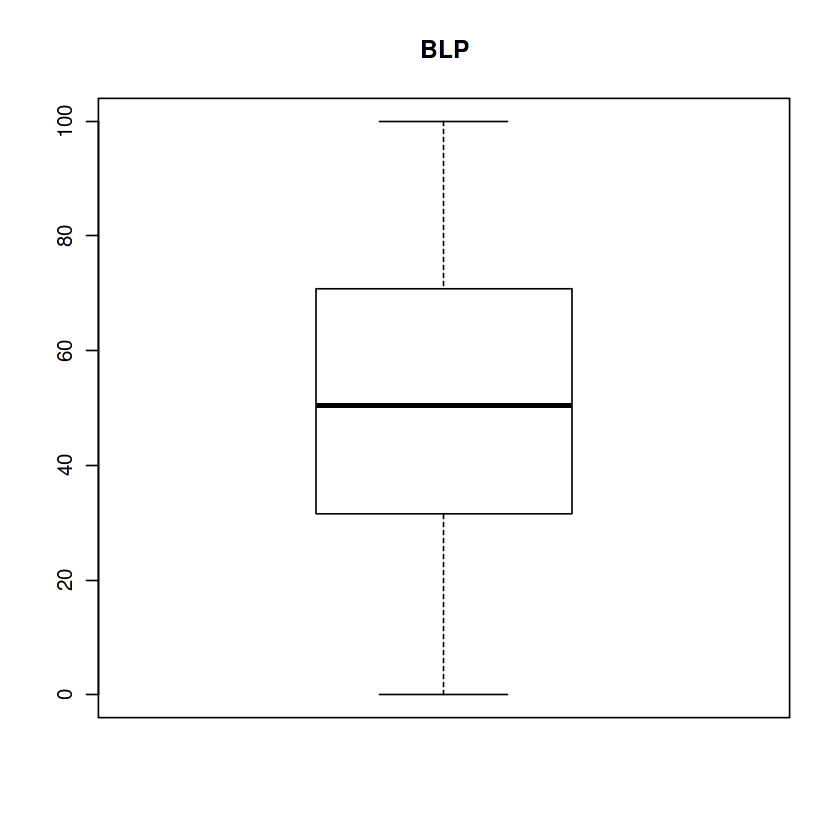

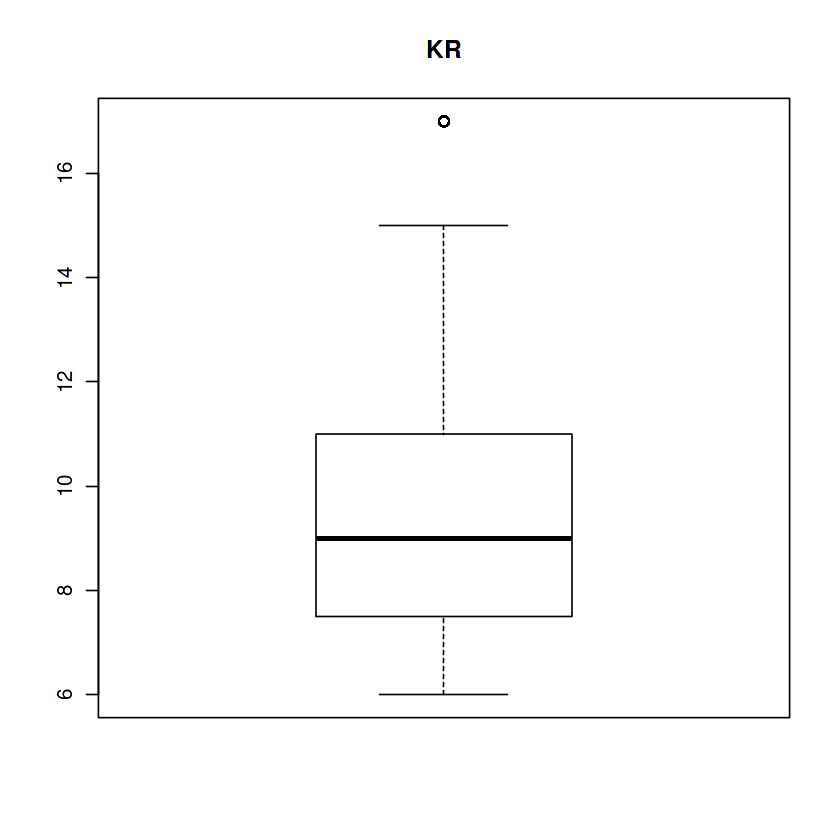

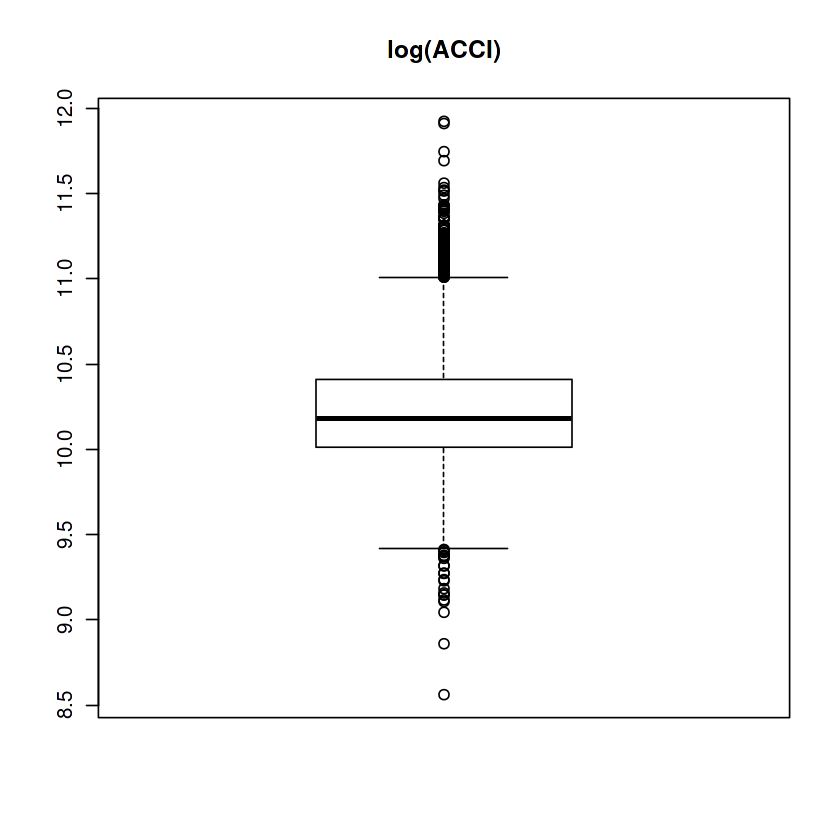

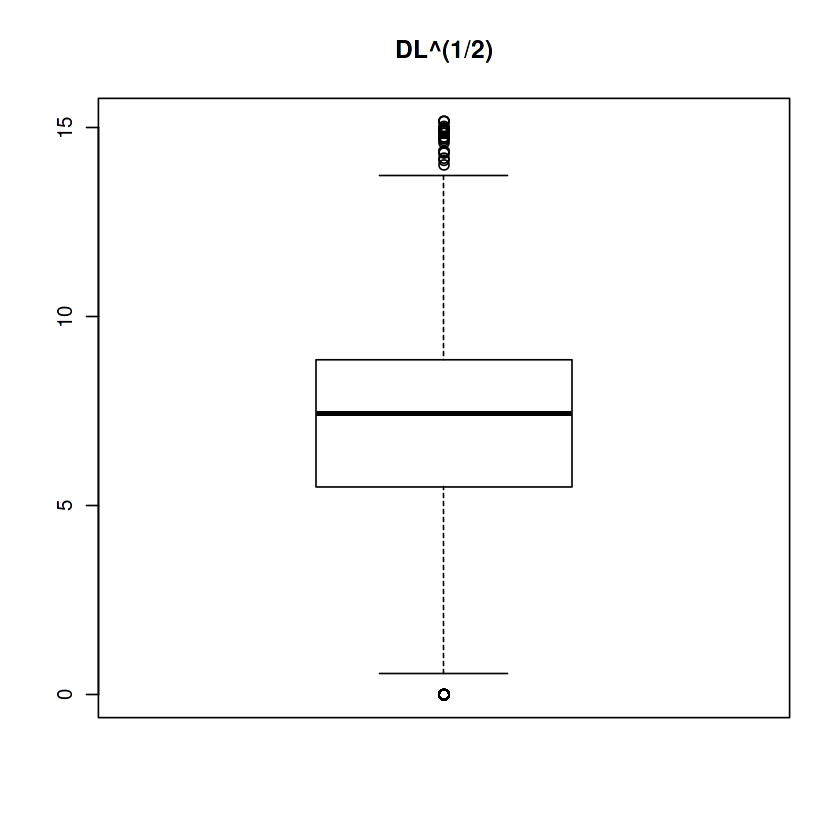

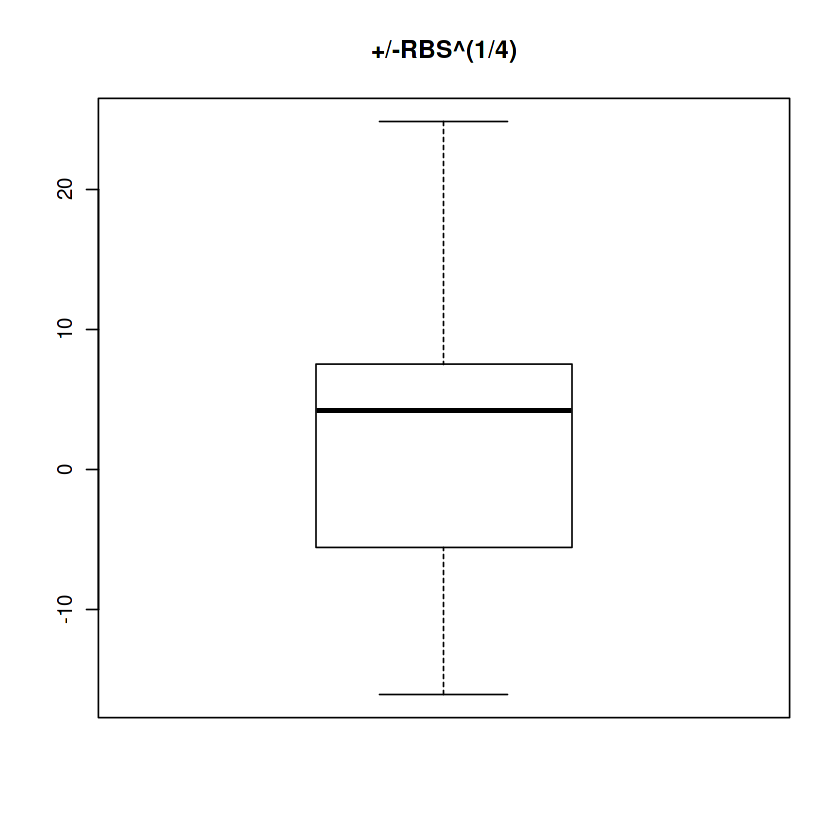

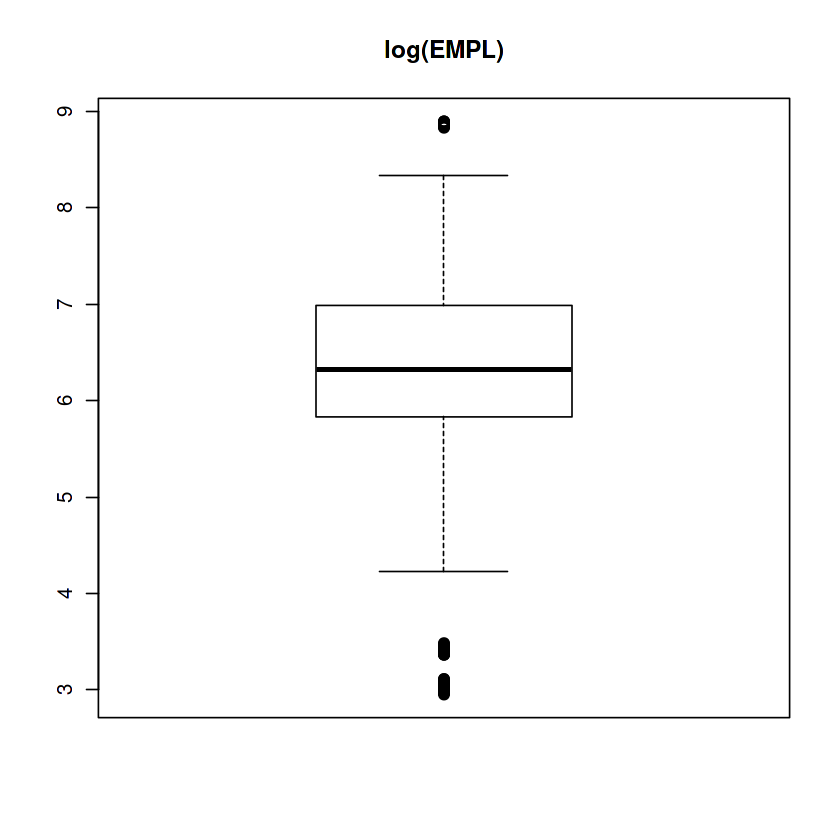

In [46]:
# look at all transformed predictors once more
boxplot(da$BLP, main = "BLP")
boxplot(da$KR, main = "KR")
boxplot(log(da$ACCI), main = "log(ACCI)")
boxplot(sqrt(da$DL), main = "DL^(1/2)")
boxplot(trans_rbs(da$RBS), main = "+/-RBS^(1/4)")
boxplot(log(da$EMPL), main = "log(EMPL)")

In [47]:
# add transformed predictors
da$logACCI <- log(da$ACCI)
da$sqrtDL <- da$DL^(1/2)
da$transRBS <- trans_rbs(da$RBS)
da$logEMPL <- log(da$EMPL)

## Data Description

In [48]:
# number of different regions
length(unique(da$region))

[1] 85

In [49]:
# number of different months
length(unique(da$month))

[1] 64

In [50]:
# January 2015 - April 2020

In [51]:
stargazer(da[, c("RBV", "BLP", "KR", "ACCI", "DL", "RBS", "EMPL")],
          type = "text",
          summary.stat=c("N", "min", "median", "mean", "sd", "max"))


Statistic   N       Min       Median       Mean         St. Dev.        Max    
-------------------------------------------------------------------------------
RBV       5,440      0          0      5,803,268.000 11,796,174.000 111,255,238
BLP       5,440    0.000      50.419      51.655         27.962       100.000  
KR        5,440      6          9          9.324         2.454          17     
ACCI      5,100  5,223.000  26,332.500  29,742.540     12,952.260   150,843.000
DL        5,133    0.000      55.360      55.137         34.171       230.190  
RBS       5,097 -67,511.000  303.900     4,782.966     24,254.230   381,541.200
EMPL      5,434   19.130     555.690      849.577       960.401      7,294.200 
-------------------------------------------------------------------------------


In [52]:
stargazer(da[, c("RBV", "BLP", "KR", "ACCI", "DL", "RBS", "EMPL")],
          type = "latex",
          summary.stat=c("N", "min", "median", "mean", "sd", "max"))


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Вт, ноя 24, 2020 - 17:29:01
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Statistic & \multicolumn{1}{c}{N} & \multicolumn{1}{c}{Min} & \multicolumn{1}{c}{Median} & \multicolumn{1}{c}{Mean} & \multicolumn{1}{c}{St. Dev.} & \multicolumn{1}{c}{Max} \\ 
\hline \\[-1.8ex] 
RBV & 5,440 & 0 & 0 & 5,803,268.000 & 11,796,174.000 & 111,255,238 \\ 
BLP & 5,440 & 0.000 & 50.419 & 51.655 & 27.962 & 100.000 \\ 
KR & 5,440 & 6 & 9 & 9.324 & 2.454 & 17 \\ 
ACCI & 5,100 & 5,223.000 & 26,332.500 & 29,742.540 & 12,952.260 & 150,843.000 \\ 
DL & 5,133 & 0.000 & 55.360 & 55.137 & 34.171 & 230.190 \\ 
RBS & 5,097 & $-$67,511.000 & 303.900 & 4,782.966 & 24,254.230 & 381,541.200 \\ 
EMPL & 5,434 & 19.130 & 555.690 & 849.577 & 960.401 & 7,294.200 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{ta

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



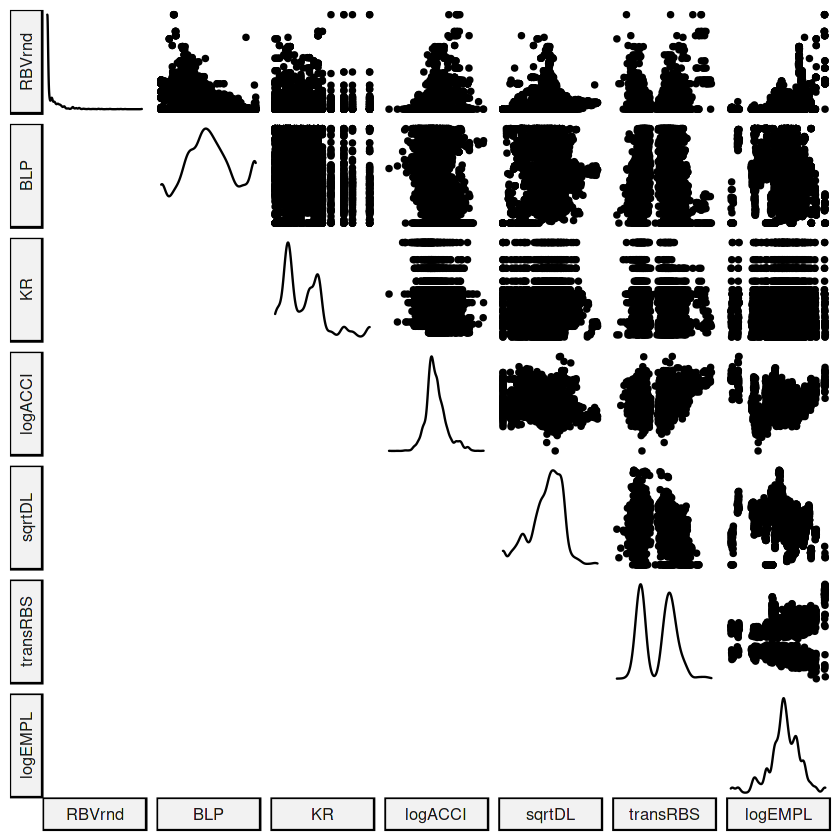

In [53]:
oldw <- getOption("warn")
options(warn = -1)
GGally::ggpairs(da[, c("RBVrnd", "BLP", "KR", "logACCI", "sqrtDL", "transRBS", "logEMPL")],
               ggplot2::aes(shape = "."),
               upper = list(continuous = "points", combo = "dot_no_facet"),
               lower = "blank",
               switch = "both" , axisLabels = "none"
               )
ggsave("pairs.eps")
options(warn = oldw)
rm(oldw)

In [54]:
#===== properties of RBVrnd as an approximation to RBV ===============

In [55]:
# proportion of zero values of RBV
round(mean(da$RBV==0)*100, 1)

[1] 51.4

In [56]:
# proportion of zero values of RBVrnd
round(mean(da$RBVrnd==0)*100, 1)

[1] 51.9

In [57]:
max(da$RBV)

[1] 111255238

In [58]:
max(da$RBVrnd)

[1] 1113

In [59]:
rel_err_prc <- function(xa, xe) {
    # relative error, %
    # xa approximate value
    # xe exact value
    stopifnot(length(xa) == length(xe))
    rele <- xe
    ok <- xe > 0
    rele[!ok] <- NA
    rele[ok] <- abs(xa[ok] - xe[ok])/xe[ok] * 100
    rele
}

In [60]:
# relative error of approximation at maximum values of RBVrnd, RBV, %
rel_err_prc(max(da$RBVrnd)*1e5, max(da$RBV))

[1] 0.04023361

In [61]:
# distribution of relative error of approximation, %
foo <- rel_err_prc(da$RBVrnd*1e5, da$RBV)
foo <- foo[!is.na(foo)]
summary(foo)
rm(foo)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.0000   0.0002   2.3487   0.3774 100.0000 

## Modeling/Presentation

### Model 1

In [62]:
cat(paste(c("BLP", "KR", "logACCI", "sqrtDL", "transRBS", "logEMPL"), collapse=" + "))

BLP + KR + logACCI + sqrtDL + transRBS + logEMPL

In [63]:
RBVnz_blogit1 <- pglm(RBVnz ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL,
                     data = da,
                     family = binomial("logit"),
                     model = "random",
                     index = "region",
                     method = "bfgs",
                     R = 20, print.level = 3
                     )

Initial function value: -1010.761 
Initial gradient value:
(Intercept)         BLP          KR     logACCI      sqrtDL    transRBS 
   8.085766 -676.561928 -104.358268  100.056445   76.417606  216.875929 
    logEMPL       sigma 
  35.905593   62.254066 
initial  value 1010.761037 
iter   2 value 1005.033305
iter   3 value 1002.818605
iter   4 value 994.799366
iter   5 value 984.777710
iter   6 value 966.568043
iter   7 value 946.975860
iter   8 value 944.817975
iter   9 value 936.763928
iter  10 value 931.040848
iter  11 value 929.052537
iter  12 value 924.659452
iter  13 value 923.061471
iter  14 value 922.759724
iter  15 value 920.181646
iter  16 value 919.683848
iter  17 value 916.450965
iter  18 value 913.141035
iter  19 value 910.883045
iter  20 value 907.371087
iter  21 value 905.368332
iter  22 value 904.271158
iter  23 value 904.178712
iter  24 value 904.169713
iter  25 value 904.164016
iter  26 value 904.148921
iter  27 value 904.148859
iter  28 value 904.143828
iter  29 valu

In [64]:
summary(RBVnz_blogit1)

--------------------------------------------
Maximum Likelihood estimation
BFGS maximization, 158 iterations
Return code 0: successful convergence 
Log-Likelihood: -904.1379 
8  free parameters
Estimates:
              Estimate Std. error t value  Pr(> t)    
(Intercept) -32.057110   3.409647  -9.402  < 2e-16 ***
BLP          -0.069156   0.004121 -16.782  < 2e-16 ***
KR           -0.477538   0.039263 -12.162  < 2e-16 ***
logACCI       2.066528   0.270772   7.632 2.31e-14 ***
sqrtDL        0.548448   0.041818  13.115  < 2e-16 ***
transRBS      0.006706   0.011817   0.567     0.57    
logEMPL       2.295670   0.127891  17.950  < 2e-16 ***
sigma         5.748332   0.272068  21.128  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [65]:
# R Stargazer with pglm model - convert binominal pglm model in plm model
# https://stackoverrun.com/ru/q/11599217

In [66]:
extract.pglm <- function (model, include.nobs = TRUE, include.loglik = TRUE, ...) {
      s <- summary(model, ...)
      coefficient.names <- rownames(s$estimate)
      coefficients <- s$estimate[, 1]
      standard.errors <- s$estimate[, 2]
      significance <- s$estimate[, 4]
      loglik.value <- s$loglik
      n <- nrow(model$model)
      gof <- numeric()
      gof.names <- character()
      gof.decimal <- logical()
      if (include.loglik == TRUE) {
         gof <- c(gof, loglik.value)
         gof.names <- c(gof.names, "Log-Likelihood")
         gof.decimal <- c(gof.decimal, TRUE)
      }
      if (include.nobs == TRUE) {
         gof <- c(gof, n)
         gof.names <- c(gof.names, "Num. obs.")
         gof.decimal <- c(gof.decimal, FALSE)
      }
      tr <- createTexreg(coef.names = coefficient.names, coef = coefficients, 
                    se = standard.errors, pvalues = significance, gof.names = gof.names, 
                    gof = gof, gof.decimal = gof.decimal)
      return(tr)
}

In [67]:
setMethod("extract", signature = className("maxLik", "maxLik"), 
         definition = extract.pglm)

In [68]:
cat(screenreg(RBVnz_blogit1))


                Model 1    
---------------------------
(Intercept)      -32.06 ***
                  (3.41)   
BLP               -0.07 ***
                  (0.00)   
KR                -0.48 ***
                  (0.04)   
logACCI            2.07 ***
                  (0.27)   
sqrtDL             0.55 ***
                  (0.04)   
transRBS           0.01    
                  (0.01)   
logEMPL            2.30 ***
                  (0.13)   
sigma              5.75 ***
                  (0.27)   
---------------------------
Log-Likelihood  -904.14    
Num. obs.       4879       
*** p < 0.001; ** p < 0.01; * p < 0.05


### Model 2

In [69]:
# add D201812 -- dummy for December 2018

In [70]:
RBVnz_blogit2 <- pglm(RBVnz ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812,
                     data = da,
                     family = binomial("logit"),
                     model = "random",
                     index = "region",
                     method = "bfgs",
                     R = 20, print.level = 3
                     )

Initial function value: -930.9917 
Initial gradient value:
(Intercept)         BLP          KR     logACCI      sqrtDL    transRBS 
   7.142501 -626.377579  -98.154864   84.133299   76.268021  177.041601 
    logEMPL     D201812       sigma 
  31.748873   14.378812   65.916860 
initial  value 930.991656 
iter   2 value 925.062188
iter   3 value 921.960561
iter   4 value 915.383185
iter   5 value 907.628299
iter   6 value 889.336955
iter   7 value 869.393710
iter   8 value 866.590948
iter   9 value 865.186673
iter  10 value 836.660928
iter  11 value 801.943364
iter  12 value 787.110039
iter  13 value 786.293161
iter  14 value 784.210138
iter  15 value 783.303047
iter  16 value 782.483032
iter  17 value 782.161877
iter  18 value 782.050640
iter  19 value 781.921196
iter  20 value 781.784316
iter  21 value 781.704503
iter  22 value 781.700311
iter  23 value 781.694780
iter  24 value 781.687356
iter  25 value 781.686678
iter  26 value 781.686157
iter  27 value 781.682892
iter  28 value 781

In [71]:
summary(RBVnz_blogit2)

--------------------------------------------
Maximum Likelihood estimation
BFGS maximization, 173 iterations
Return code 0: successful convergence 
Log-Likelihood: -780.3072 
9  free parameters
Estimates:
              Estimate Std. error t value  Pr(> t)    
(Intercept) -27.792249   3.729345  -7.452 9.17e-14 ***
BLP          -0.100141   0.005598 -17.889  < 2e-16 ***
KR           -0.550330   0.044588 -12.342  < 2e-16 ***
logACCI       1.676146   0.296646   5.650 1.60e-08 ***
sqrtDL        0.873201   0.057812  15.104  < 2e-16 ***
transRBS      0.010771   0.012788   0.842      0.4    
logEMPL       2.102946   0.126394  16.638  < 2e-16 ***
D201812       9.526570   0.856904  11.117  < 2e-16 ***
sigma         5.434631   0.266483  20.394  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [72]:
AICtab(RBVnz_blogit1, RBVnz_blogit2)

              dAIC  df
RBVnz_blogit2   0.0 9 
RBVnz_blogit1 245.7 8 

### Model 3

In [73]:
# logit model for non-zero values of RBV
RBVnz_glmm2 <- glmmTMB(RBVnz ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +
                       (1|region),
                          REML = FALSE,
                       family = binomial,
                       data=da,
                       control = glmmTMBControl(optCtrl=list(iter.max=1e5,
                                                             eval.max=1e5)))

In [74]:
summary(RBVnz_glmm2)

 Family: binomial  ( logit )
Formula:          
RBVnz ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +  
    (1 | region)
Data: da

     AIC      BIC   logLik deviance df.resid 
  1505.4   1563.8   -743.7   1487.4     4870 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 region (Intercept) 60.84    7.8     
Number of obs: 4879, groups:  region, 85

Conditional model:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -29.864649   7.935685  -3.763 0.000168 ***
BLP          -0.086856   0.007178 -12.100  < 2e-16 ***
KR           -0.574747   0.051294 -11.205  < 2e-16 ***
logACCI       0.966155   0.509066   1.898 0.057709 .  
sqrtDL        1.012490   0.127507   7.941 2.01e-15 ***
transRBS      0.021639   0.014875   1.455 0.145750    
logEMPL       3.587068   0.849922   4.220 2.44e-05 ***
D201812      11.102880   1.003784  11.061  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [75]:
AICtab(RBVnz_blogit1, RBVnz_blogit2, RBVnz_glmm2)

              dAIC  df
RBVnz_glmm2     0.0 9 
RBVnz_blogit2  73.2 9 
RBVnz_blogit1 318.9 8 

In [76]:
cairo_ps("model3_dharma.eps")
simulateResiduals(fittedModel = RBVnz_glmm2, plot = T)
dev.off()

Object of Class DHARMa with simulated residuals based on 250 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.9509462 0.0828558 0.2161761 0.8211981 0.02037314 0.7641814 0.8130425 0.8353219 0.04639832 0.02155669 0.8575092 0.8222198 0.02970546 0.7119871 0.7538191 0.5156913 0.8204607 0.9420806 0.02427104 0.7260063 ...

png 
  2

In [77]:
# random effects both for region and time
RBVnz_glmm3 <- glmmTMB(RBVnz ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +
                       (1|region) + (1|month),
                          REML = FALSE,
                       family = binomial,
                       data=da,
                       control = glmmTMBControl(optCtrl=list(iter.max=1e5,
                                                             eval.max=1e5)))

In [78]:
AICtab(RBVnz_blogit1, RBVnz_blogit2, RBVnz_glmm2, RBVnz_glmm3)

              dAIC  df
RBVnz_glmm2     0.0 9 
RBVnz_glmm3     1.4 10
RBVnz_blogit2  73.2 9 
RBVnz_blogit1 318.9 8 

In [79]:
# RBVnz_glmm3 is not better
rm(RBVnz_glmm3)

### Model 4

In [80]:
# AR(1) residuals
RBVnz_glmm4 <- glmmTMB(RBVnz ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +
                       ar1(month + 0|region),
                          REML = FALSE,
                       family = binomial,
                       data=da,
                       control = glmmTMBControl(optCtrl=list(iter.max=1e5,
                                                             eval.max=1e5)))

In [81]:
summary(RBVnz_glmm4)

 Family: binomial  ( logit )
Formula:          
RBVnz ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +  
    ar1(month + 0 | region)
Data: da

     AIC      BIC   logLik deviance df.resid 
   557.2    622.1   -268.6    537.2     4869 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev. Corr      
 region monthmonth2 48910    221.2    0.99 (ar1)
Number of obs: 4879, groups:  region, 85

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 16.31228   41.46083   0.393    0.694    
BLP         -0.07803    0.06527  -1.195    0.232    
KR          -5.23138    1.25830  -4.157 3.22e-05 ***
logACCI     -0.65273    3.44742  -0.189    0.850    
sqrtDL       0.55008    0.76768   0.717    0.474    
transRBS    -0.11470    0.16010  -0.716    0.474    
logEMPL      1.82122    1.76587   1.031    0.302    
D201812     37.92729    6.51341   5.823 5.78e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [82]:
AICtab(RBVnz_blogit1, RBVnz_blogit2, RBVnz_glmm2, RBVnz_glmm4)

              dAIC   df
RBVnz_glmm4      0.0 10
RBVnz_glmm2    948.2 9 
RBVnz_blogit2 1021.4 9 
RBVnz_blogit1 1267.1 8 

In [83]:
# RBVnz_glmm4 is significantly better than RBVnz_glmm2

In [84]:
# LaTeX presenting of models for RBVnz
cat(texreg(list(RBVnz_blogit1, RBVnz_blogit2, RBVnz_glmm2, RBVnz_glmm4),
           custom.model.names = c("Model 1", "Model 2", "Model 3", "Model 4"),
           caption = "Response RBVnz: Models 1, 2 estimated with pgls, Model 3, 4 with glmmTMB",
           label = "tab:model1234",
           bold = 0.05,
           custom.note = "Coefficients with $p < 0.05$ in \\textbf{bold}.",
           caption.above = TRUE, digits = 3))


\begin{table}
\caption{Response RBVnz: Models 1, 2 estimated with pgls, Model 3, 4 with glmmTMB}
\begin{center}
\begin{tabular}{l c c c c}
\hline
 & Model 1 & Model 2 & Model 3 & Model 4 \\
\hline
(Intercept)              & $\mathbf{-32.057}^{***}$ & $\mathbf{-27.792}^{***}$ & $\mathbf{-29.865}^{***}$ & $16.312$                \\
                         & $(3.410)$                & $(3.729)$                & $(7.936)$                & $(41.461)$              \\
BLP                      & $\mathbf{-0.069}^{***}$  & $\mathbf{-0.100}^{***}$  & $\mathbf{-0.087}^{***}$  & $-0.078$                \\
                         & $(0.004)$                & $(0.006)$                & $(0.007)$                & $(0.065)$               \\
KR                       & $\mathbf{-0.478}^{***}$  & $\mathbf{-0.550}^{***}$  & $\mathbf{-0.575}^{***}$  & $\mathbf{-5.231}^{***}$ \\
                         & $(0.039)$                & $(0.045)$                & $(0.051)$                & $(1.258)$          

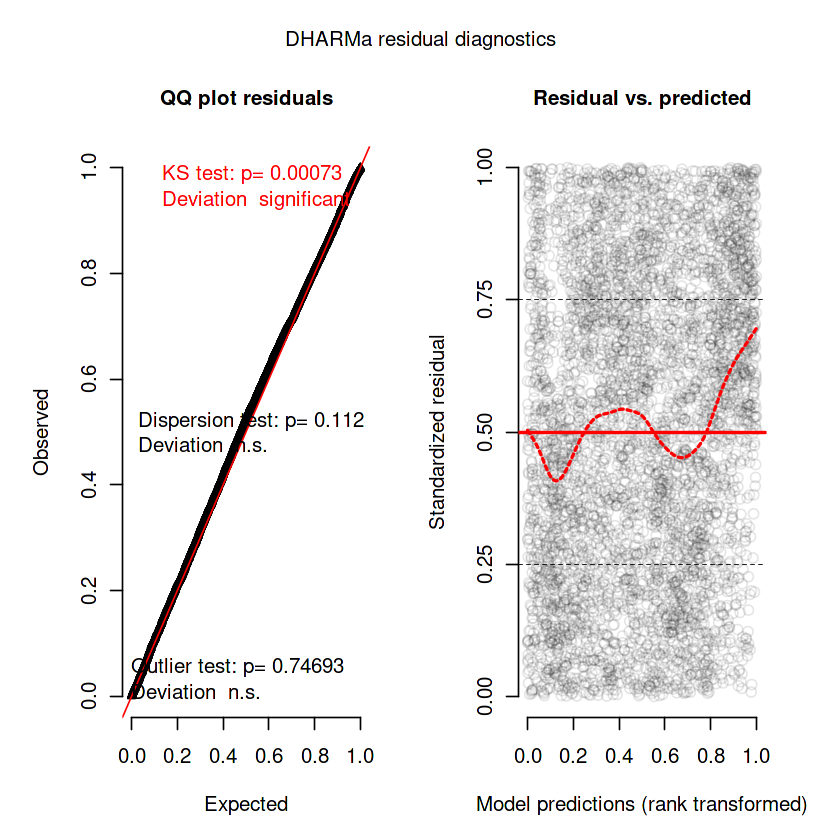

In [85]:
simulationOutput <- simulateResiduals(fittedModel = RBVnz_glmm4, plot = T)


	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
ratioObsSim = 0.98302, p-value = 0.112
alternative hypothesis: two.sided


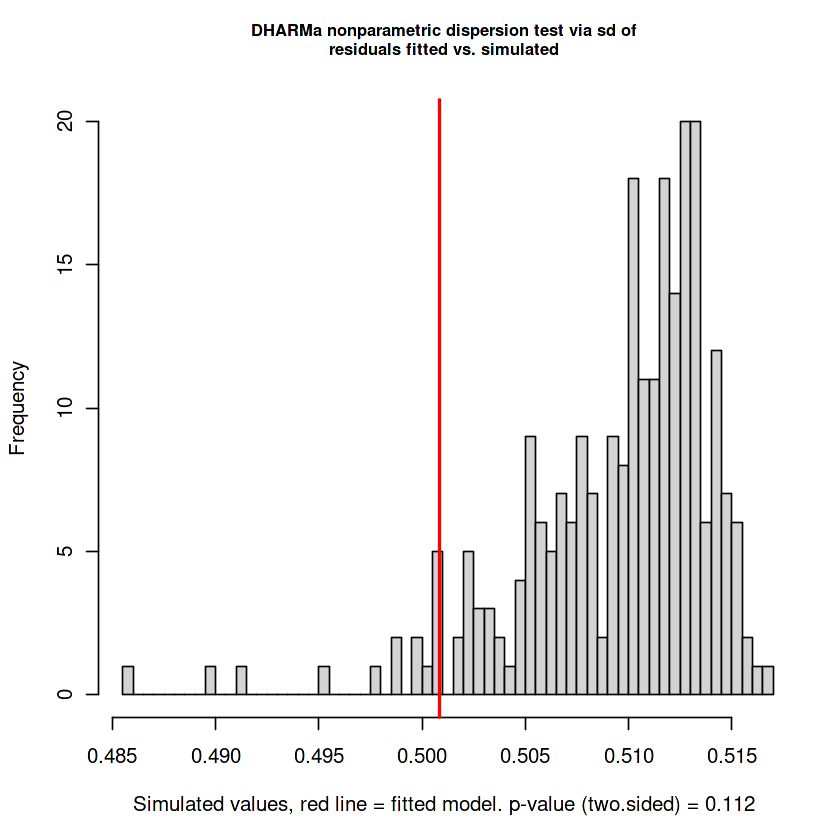

In [86]:
testDispersion(simulationOutput)

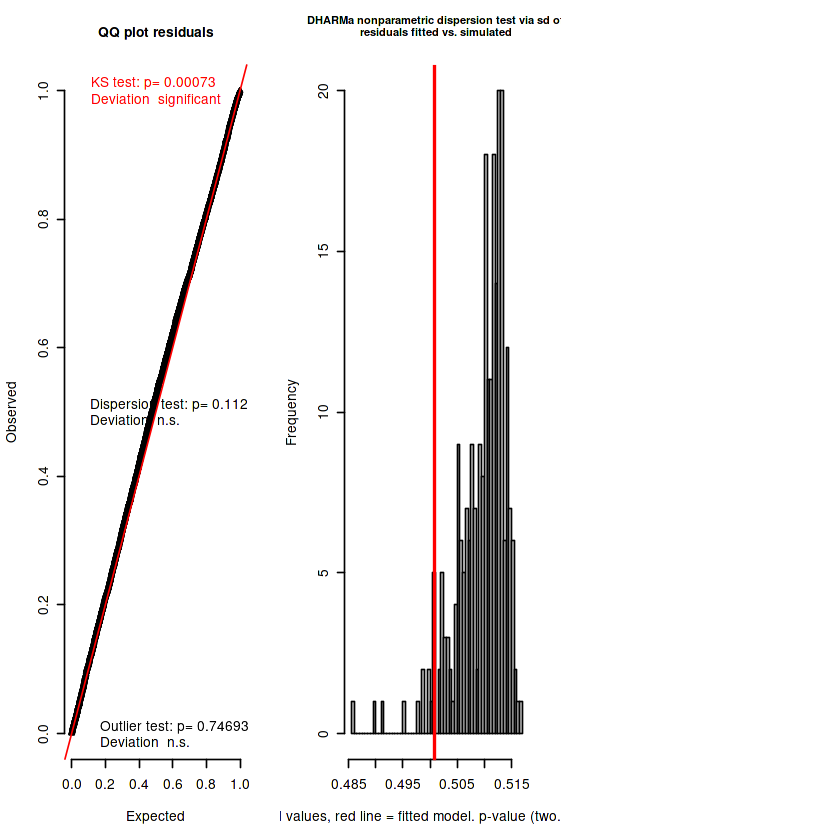

$uniformity

	One-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.028486, p-value = 0.0007281
alternative hypothesis: two-sided


$dispersion

	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
ratioObsSim = 0.98302, p-value = 0.112
alternative hypothesis: two.sided


$outliers

	DHARMa bootstrapped outlier test

data:  simulationOutput
outliers at both margin(s) = 0, observations = 4879, p-value = 1
alternative hypothesis: two.sided
 percent confidence interval:
 0 0
sample estimates:
outlier frequency (expected: 0 ) 
                               0 




$uniformity

	One-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.028486, p-value = 0.0007281
alternative hypothesis: two-sided


$dispersion

	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
ratioObsSim = 0.98302, p-value = 0.112
alternative hypothesis: two.sided


$outliers

	DHARMa bootstrapped outlier test

data:  simulationOutput
outliers at both margin(s) = 0, observations = 4879, p-value = 1
alternative hypothesis: two.sided
 percent confidence interval:
 0 0
sample estimates:
outlier frequency (expected: 0 ) 
                               0 



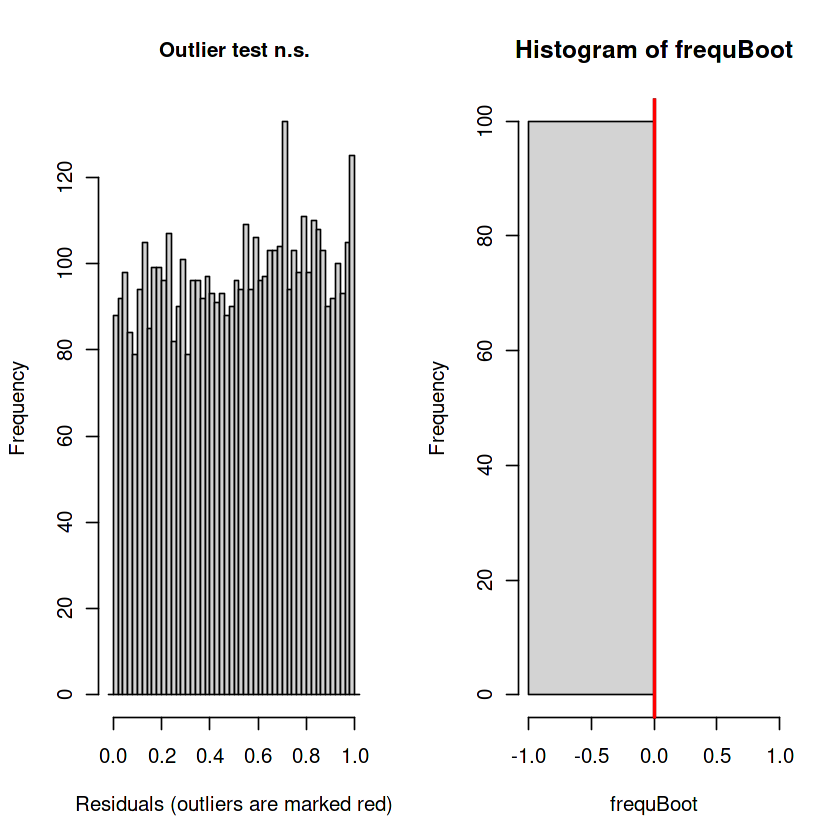

In [87]:
testResiduals(simulationOutput)


	DHARMa generic simulation test

data:  RBVnz_glmm4
ratioObsSim.Min. = 0.0000, ratioObsSim.1st Qu. = 0.0000,
ratioObsSim.Median = 0.0000, ratioObsSim.Mean = 1.1268, ratioObsSim.3rd
Qu. = 2.3384, ratioObsSim.Max. = 2.3384, p-value = 1
alternative hypothesis: two.sided


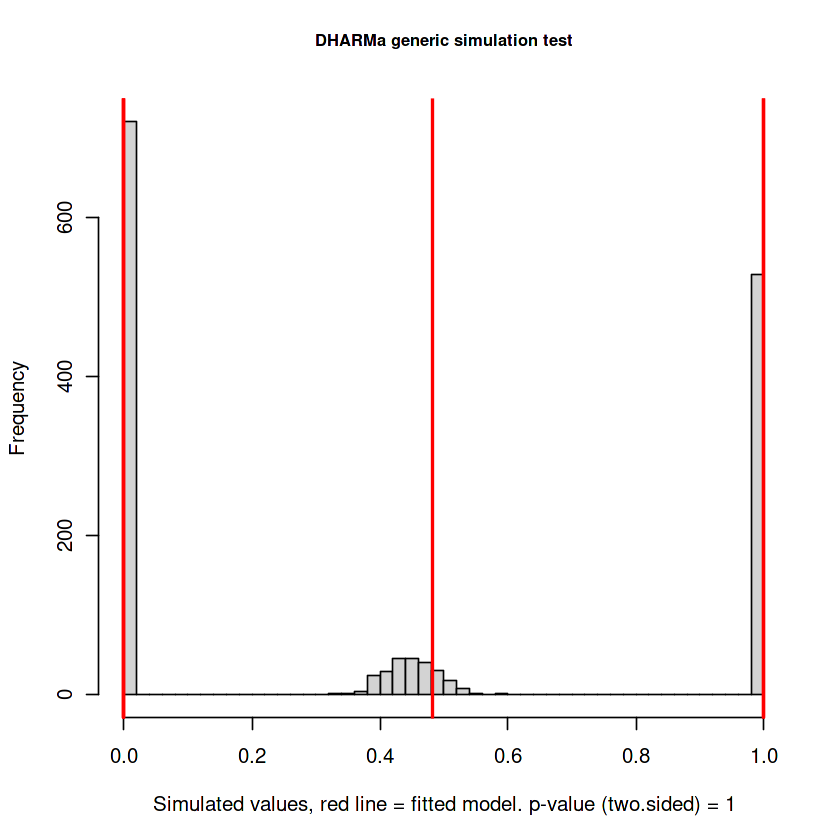

In [88]:
testGeneric(RBVnz_glmm4, simulationOutput)

DHARMa::testTemporalAutocorrelation - no time argument provided, using random times for each data point




	Durbin-Watson test

data:  simulationOutput$scaledResiduals ~ 1
DW = 1.9805, p-value = 0.4951
alternative hypothesis: true autocorrelation is not 0


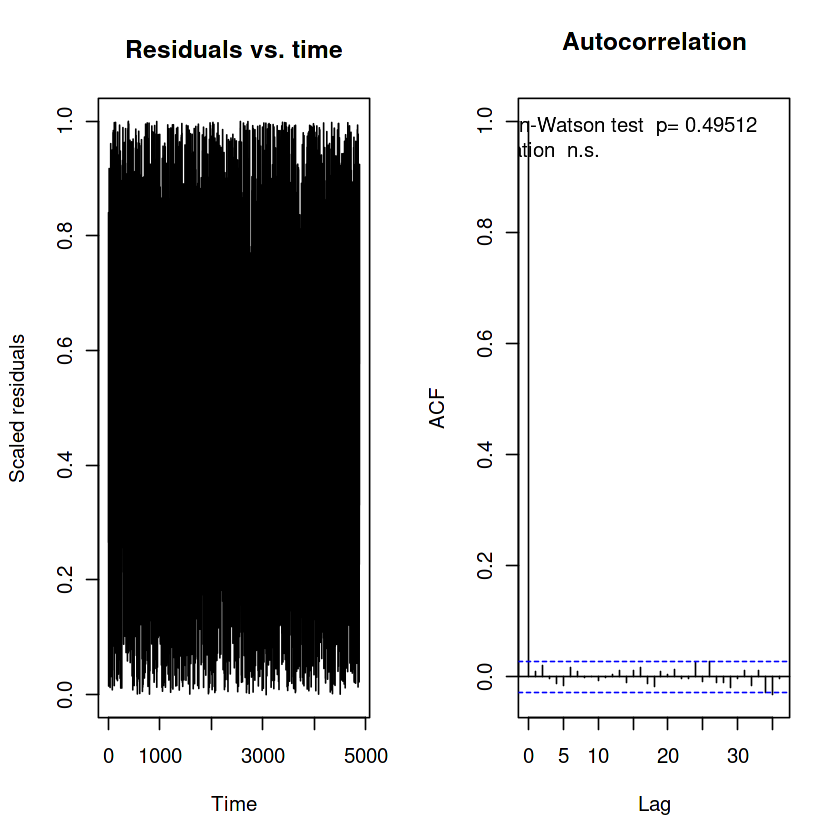

In [89]:
testTemporalAutocorrelation(simulationOutput)

### Model 5

In [90]:
# truncated Poisson for RBVrnd
RBVrnd_poisson1 <- glmmTMB(RBVrnd ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +
                       ar1(month + 0|region),
                          REML = FALSE,
                       family = "truncated_poisson",
                           ziformula = ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +
                       ar1(month + 0|region),
                       data=da,
                       control = glmmTMBControl(optCtrl=list(iter.max=1e5,
                                                             eval.max=1e5)))

In [91]:
summary(RBVrnd_poisson1)

 Family: truncated_poisson  ( log )
Formula:          
RBVrnd ~ BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 +  
    ar1(month + 0 | region)
Zero inflation:          
~BLP + KR + logACCI + sqrtDL + transRBS + logEMPL + D201812 + 
    ar1(month + 0 | region)
Data: da

     AIC      BIC   logLik deviance df.resid 
 20159.5  20289.4 -10059.8  20119.5     4859 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev. Corr      
 region monthmonth2 0.9818   0.9908   0.98 (ar1)
Number of obs: 4879, groups:  region, 85

Zero-inflation model:
 Groups Name         Variance Std.Dev. Corr                                   
 region monthmonth2  48910    221.2                                           
        monthmonth3  48910    221.2    0.99                                   
        monthmonth4  48910    221.2    0.98 0.99                              
        monthmonth5  48910    221.2    0.97 0.98 0.99                         
        monthmonth6  48910    22

In [92]:
names(summary(RBVrnd_poisson1))

[1] "logLik"       "family"       "link"         "ngrps"        "nobs"        
 [6] "coefficients" "sigma"        "vcov"         "varcor"       "AICtab"      
[11] "call"

In [93]:
# by hand extraction of information to present, omitting unneeded gof statistics

In [94]:
foo <- extract(RBVrnd_poisson1)

In [95]:
# foo@gof.names

In [96]:
foo@gof.names[c(-(6:62),-(65:121))]

[1] "AIC"                                   
[2] "Log Likelihood"                        
[3] "Num. obs."                             
[4] "Num. groups: region"                   
[5] "Var (count model): region monthmonth2" 
[6] "Var (count model): region monthmonth60"
[7] "Var (zero model): region monthmonth2"  
[8] "Var (zero model): region monthmonth60"

In [97]:
foo@gof.names <- foo@gof.names[c(-(6:62),-(65:121))]
foo@gof <- foo@gof[c(-(6:62),-(65:121))]
foo@gof.decimal <- foo@gof.decimal[c(-(6:62),-(65:121))]

In [98]:
cat(screenreg(foo))


                                        Model 1      
-----------------------------------------------------
Count model: (Intercept)                     0.37    
                                            (0.79)   
Count model: BLP                            -0.00 ***
                                            (0.00)   
Count model: KR                             -0.00    
                                            (0.01)   
Count model: logACCI                         0.00    
                                            (0.03)   
Count model: sqrtDL                          0.02    
                                            (0.02)   
Count model: transRBS                       -0.00    
                                            (0.00)   
Count model: logEMPL                         0.56 ***
                                            (0.10)   
Count model: D201812                         0.39 ***
                                            (0.03)   
Zero model: (Intercept)    

In [99]:
cat(texreg(foo,
           custom.model.names = c("Model 5"),
           caption = "Response RBVrnd: Model 5 estimated with glmmTMB",
           label = "tab:model5",
           bold = 0.05,
           custom.note = "Coefficients with $p < 0.05$ in \\textbf{bold}.",
           caption.above = TRUE, digits = 3))


\begin{table}
\caption{Response RBVrnd: Model 5 estimated with glmmTMB}
\begin{center}
\begin{tabular}{l c}
\hline
 & Model 5 \\
\hline
Count model: (Intercept)               & $0.373$                  \\
                                       & $(0.786)$                \\
Count model: BLP                       & $\mathbf{-0.004}^{***}$  \\
                                       & $(0.001)$                \\
Count model: KR                        & $-0.001$                 \\
                                       & $(0.010)$                \\
Count model: logACCI                   & $0.004$                  \\
                                       & $(0.030)$                \\
Count model: sqrtDL                    & $0.019$                  \\
                                       & $(0.019)$                \\
Count model: transRBS                  & $-0.002$                 \\
                                       & $(0.001)$                \\
Count model: logEMPL               

In [100]:
rm(foo)

DHARMa:plot used testOutliers with type = binomial for computational reasons (nObs > 500). Note that this method may not have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details



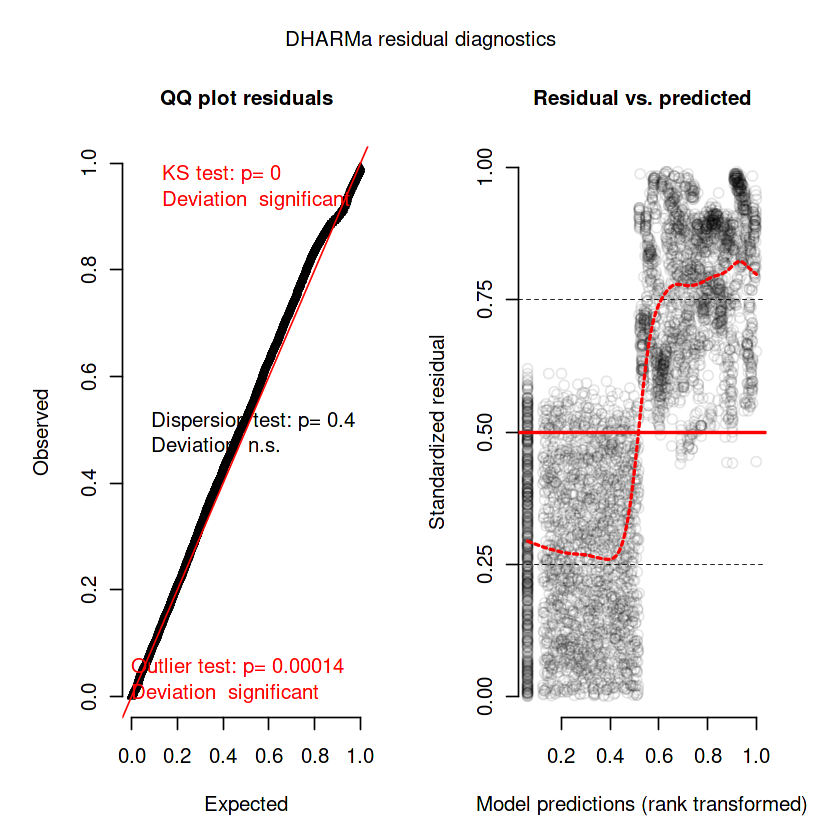

In [101]:
simulationOutput <- simulateResiduals(fittedModel = RBVrnd_poisson1, plot = T)

In [102]:
cairo_ps("model5_dharma.eps")
simulateResiduals(fittedModel = RBVrnd_poisson1, plot = T)
dev.off()

DHARMa:plot used testOutliers with type = binomial for computational reasons (nObs > 500). Note that this method may not have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details



Object of Class DHARMa with simulated residuals based on 250 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.856 0.2842863 0.4782033 0.892 0.5845275 0.6786187 0.8369399 0.872244 0.05792241 0.4903138 0.704 0.7712327 0.5403825 0.812 0.78 0.896 0.844 0.94 0.04579348 0.8 ...

png 
  2

In [103]:
# random effects extraction

In [104]:
RBVnz_glmm4_RE <- ranef(RBVnz_glmm4)

In [105]:
# conditional part
RBVnz_glmm4_RE$cond

,monthmonth2,monthmonth3,monthmonth4,monthmonth5,monthmonth6,monthmonth7,monthmonth8,monthmonth9,monthmonth10,monthmonth11,⋯,monthmonth51,monthmonth52,monthmonth53,monthmonth54,monthmonth55,monthmonth56,monthmonth57,monthmonth58,monthmonth59,monthmonth60
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Алтайский край,0.059459604,0.060156817,0.060862205,0.061575864,0.062297891,0.063028385,0.063767445,0.064515170,0.065271664,0.066037028,⋯,0.098128515,0.096979613,0.095843899,0.094721216,0.093611415,0.09251446,0.091430188,0.090358474,0.089300699,0.088260548
Амурская область,-0.008127897,-0.008223203,-0.008319627,-0.008417181,-0.008515880,-0.008615735,-0.008716762,-0.008818973,-0.008922383,-0.009027005,⋯,-0.013786326,-0.013894900,-0.014005001,-0.014116722,-0.014230053,-0.01434418,-0.014457137,-0.014568542,-0.014669956,-0.014635982
Архангельская область,-0.015203550,-0.015381824,-0.015562189,-0.015744668,-0.015929287,-0.016116071,-0.016305045,-0.016496235,-0.016689667,-0.016885367,⋯,-0.024042597,-0.024096558,-0.024153428,-0.024213471,-0.024276730,-0.02434272,-0.024410983,-0.024481658,-0.024550414,-0.024540895
Астраханская область,-0.005534142,-0.005599035,-0.005664688,-0.005731111,-0.005798313,-0.005866303,-0.005935090,-0.006004684,-0.006075094,-0.006146329,⋯,-0.007831099,-0.007760621,-0.007690866,-0.007621923,-0.007553906,-0.00748654,-0.007418878,-0.007350757,-0.007282833,-0.007206854
Белгородская область,68.656106290,67.860517516,67.074049286,66.296691796,65.528334244,64.768882065,64.018232062,63.276282220,62.542931707,61.818080861,⋯,38.780186413,38.330752412,37.886524673,37.447440338,37.013437410,36.58446099,36.160454500,35.741359321,35.327120168,34.917681892
Брянская область,0.024254946,0.024539355,0.024827099,0.025118217,0.025412749,0.025710734,0.026012214,0.026317228,0.026625819,0.026938029,⋯,0.040119425,0.039638827,0.039163651,0.038693809,0.038229239,0.03776991,0.037315877,0.036867088,0.036423939,0.035994014
Владимирская область,0.052834248,0.053453773,0.054080563,0.054714702,0.055356276,0.056005374,0.056662083,0.057326492,0.057998693,0.058678775,⋯,0.087201845,0.086181861,0.085173597,0.084176914,0.083191679,0.08221784,0.081255264,0.080303835,0.079363749,0.078439253
Волгоградская область,69.578205852,68.771916792,67.974879992,67.187074922,66.408387091,65.638724241,64.877981778,64.126056318,63.382845672,62.648248838,⋯,39.300486838,38.845004734,38.394800845,37.949813073,37.509980405,37.07524434,36.645546330,36.220827813,35.801031451,35.386100460
Вологодская область,70.826197859,69.623915370,68.430924549,67.247229073,66.072645630,64.907041498,63.750258317,62.602138878,61.462527151,60.331268261,⋯,8.943671447,8.810120379,8.678185164,8.547710928,8.418656622,8.29162880,8.166278748,8.042560398,7.921590379,7.817064111


In [106]:
plot_re_cond <- function(mRE, regi, ystart, mstart) {
    # plot random effects for a specified region
    # mRE estimates of random effects
    # regi region (string)
    # ystart год начала
    # mstart месяц начала (того, что в таблице)
    
    recond <- mRE$cond$region
    rown <- row.names(recond)
    
    x <- recond[rown == regi, ]
    
    coln <- colnames(x) 
    stopifnot(coln[1] == "monthmonth2")
    
    cat("====================================\n")
    xxts <- ts(as.numeric(x[1, ]), start = c(ystart, mstart), freq = 12)
    print(signif(xxts, 4))
    
    autoplot(xxts) +
    geom_point(aes(y = xxts), size = 1.5, shape = 16, color = "black") +
    xlab('Year') + ylab('Random effect') +
    theme(text = element_text(size = 14))
}

In [107]:
p1 <- plot_re_cond(ranef(RBVnz_glmm4), "Саратовская область", 2015, 2)
p2 <- plot_re_cond(ranef(RBVrnd_poisson1), "Саратовская область", 2015, 2)

        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2015         9.394  9.504  9.615  9.728  9.842  9.957 10.070 10.190 10.310
2016 10.680 10.800 10.930 11.060 11.190 11.320 11.450 11.590 11.720 11.860
2017 12.280 12.430 12.570 12.720 12.870 13.020 13.180 13.480 13.800 14.170
2018 25.940 26.310 26.520 26.720 26.910 27.100 27.280 27.460 27.630 27.800
2019 28.170 28.210 28.200 28.180 28.100 27.940 27.680 27.390 27.090 26.790
        Nov    Dec
2015 10.430 10.560
2016 12.000 12.140
2017 15.430 25.300
2018 27.940 28.050
2019 26.480 26.170
         Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep
2015         -0.2512 -0.2552 -0.2594 -0.2635 -0.2678 -0.2721 -0.2765 -0.2809
2016 -0.2995 -0.3043 -0.3092 -0.3142 -0.3192 -0.3244 -0.3296 -0.3349 -0.3403
2017 -0.3628 -0.3686 -0.3746 -0.3806 -0.3867 -0.3930 -0.3993 -0.4057 -0.4123
2018 -0.4247 -0.4261 -0.4353 -0.4269 -0.4232 -0.4204 -0.4154 -0.4085 -0.3889
2019 -0.1261 -0.3367 -0.4028 -0.4138 -0.4144 -0.412

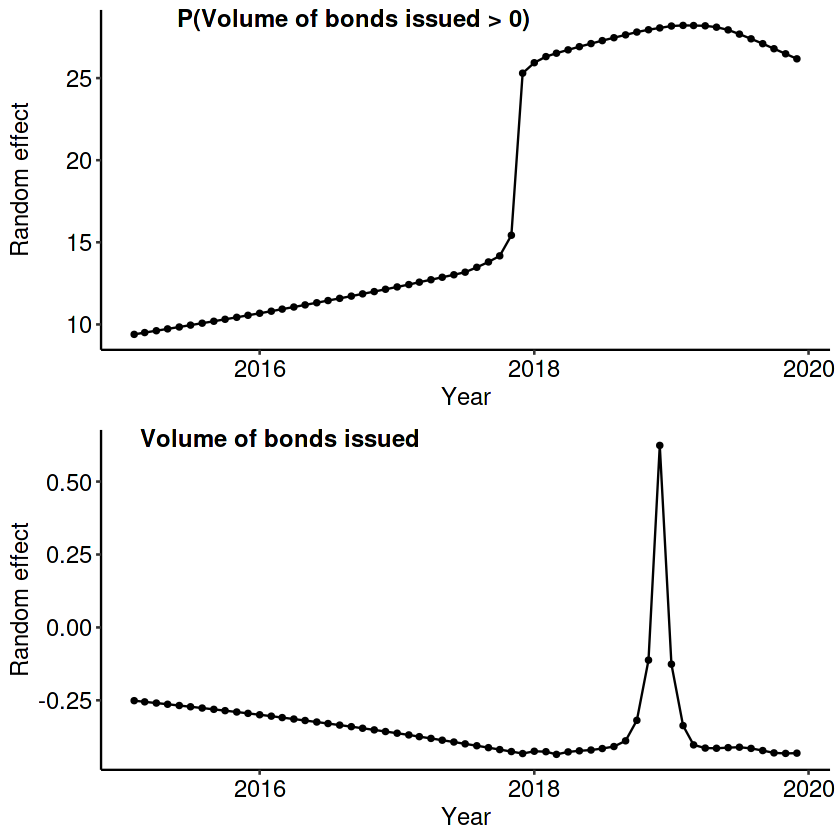

In [108]:
figure <- ggarrange(p1, p2,
                    labels = c("P(Volume of bonds issued > 0)", "Volume of bonds issued"),
                    ncol = 1, nrow = 2, align = "v")
figure

In [109]:
ggsave("Saratov.eps")

Saving 6.67 x 6.67 in image



In [110]:
p1 <- plot_re_cond(ranef(RBVnz_glmm4), "г. Москва", 2015, 2)
p2 <- plot_re_cond(ranef(RBVrnd_poisson1), "г. Москва", 2015, 2)

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
2015       35.03 35.44 35.85 36.27 36.70 37.13 37.56 38.00 38.45 38.90 39.36
2016 39.82 40.28 40.05 39.82 39.59 39.37 39.16 38.95 38.74 38.54 38.35 38.16
2017 37.98 37.54 37.11 36.69 36.27 35.85 35.44 35.03 34.63 34.24 33.84 33.46
2018 33.07 32.70 32.32 31.95 31.59 31.23 30.87 30.52 30.17 29.83 29.49 29.15
2019 28.82 28.48 28.15 27.83 27.50 27.19 26.87 26.56 26.25 25.95 25.65 25.35
        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2015        1.1300 1.1490 1.1670 1.1860 1.2050 1.2240 1.2440 1.2640 1.2850
2016 1.3480 1.3690 1.3200 1.2710 1.2220 1.1730 1.1250 1.0770 1.0300 0.9824
2017 0.8417 0.8042 0.7669 0.7297 0.6928 0.6560 0.6195 0.5830 0.5467 0.5106
2018 0.4029 0.3926 0.3824 0.3723 0.3622 0.3523 0.3425 0.3327 0.3230 0.3134
2019 0.2851 0.2806 0.2762 0.2718 0.2675 0.2632 0.2591 0.2550 0.2509 0.2469
        Nov    Dec
2015 1.3050 1.3260
2016 0.9352 0.8884
2017 0.4746 0.4387
2018 0.3039 

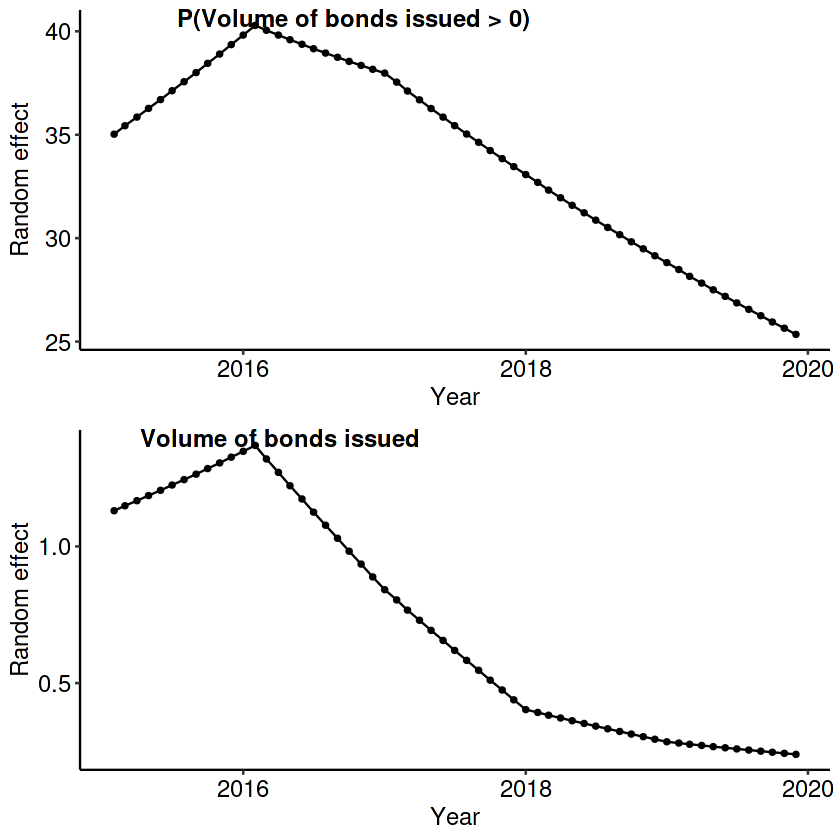

In [111]:
figure <- ggarrange(p1, p2,
                    labels = c("P(Volume of bonds issued > 0)", "Volume of bonds issued"),
                    ncol = 1, nrow = 2, align = "v")
figure

In [112]:
ggsave("Moscow.eps")

Saving 6.67 x 6.67 in image



In [113]:
ls()

[1] "da"               "extract.pglm"     "figure"           "lastFuncGrad"    
 [5] "lastFuncParam"    "p1"               "p2"               "plot_re_cond"    
 [9] "RBVnz_blogit1"    "RBVnz_blogit2"    "RBVnz_glmm2"      "RBVnz_glmm4"     
[13] "RBVnz_glmm4_RE"   "RBVrnd_poisson1"  "rel_err_prc"      "simulationOutput"
[17] "trans_rbs"

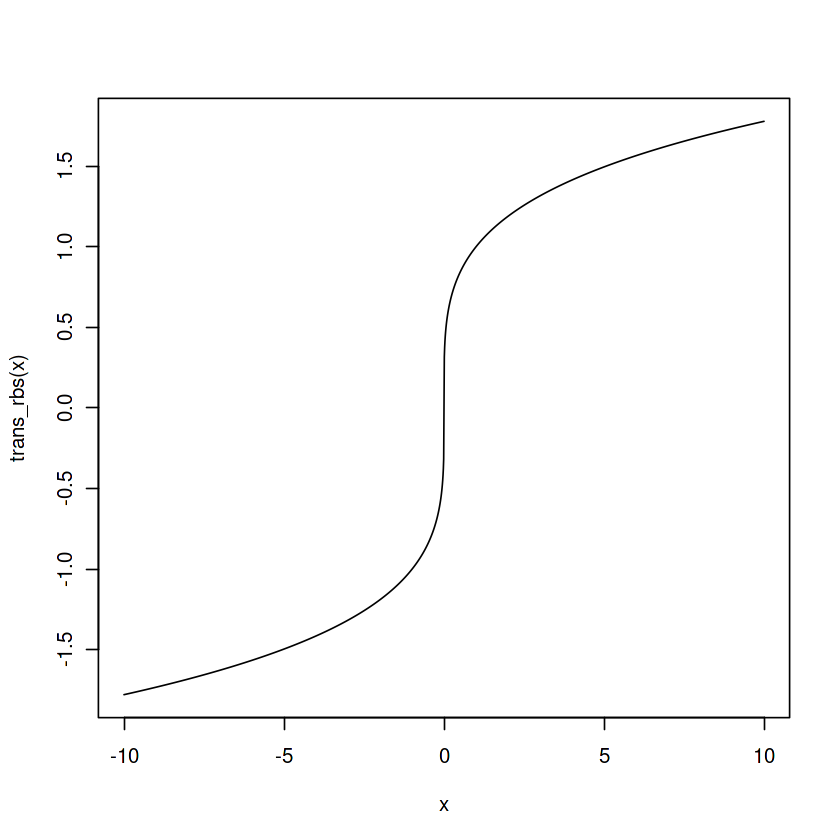

In [116]:
x <- seq(-10, 10, by = 0.01)
plot(x, trans_rbs(x), type = "l")